# 3 point - DG

Here we compare the two types of loss targets and the MSE vs MAE loss functions. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-19 19:37:05.840242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 19:37:05.858307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 19:37:05.863696: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [5]:
# We need one place to save all the experiment relevant info.  
common_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated',
                                          'uphp_rotated_nondim',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated_nondim'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],


                    #'all_time_range': slice(200, -1),
                    #'train_time_range': slice(0, 2048),
                    #'test_time_range' : slice(-128, None),
                    #'eval_time_range' : slice(-256, -128),
                    #'num_train_batches': 128, 
                    #'num_test_batches' : 8, 

                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/'
                    
            }
common_config['num_inputs'] = 6* common_config['window_size']**2

In [6]:
common_config['all_time_range'] = slice(-256,None)
common_config['eval_time_range'] = slice(-256,-128)

In [7]:
experiment_config = {'dim_MSE': {'loss_type':'mse', 
                                 'output_channels': ['uphp_rotated','vphp_rotated'],
                                 'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 
                                 'use_coeff_channels': True, 
                                 'extra_channels': [] }, 
                     'nondim_MSE': {'loss_type':'mse', 
                                    'output_channels': ['uphp_rotated_nondim','vphp_rotated_nondim'],
                                    'coeff_channels'  : [], 
                                    'use_coeff_channels': False,
                                    'extra_channels' : ['uphp_rotated',
                                                        'vphp_rotated', 
                                                        'mag_nabla_h_widened',
                                                        'mag_nabla_u_widened',
                                                        'filter_scale'],},
                     'dim_MAE': {'loss_type':'mae', 
                                 'output_channels': ['uphp_rotated','vphp_rotated'],
                                 'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'],
                                 'use_coeff_channels': True,
                                 'extra_channels': [] }, 
                     'nondim_MAE': {'loss_type':'mae', 
                                    'output_channels': ['uphp_rotated_nondim','vphp_rotated_nondim'],
                                    'coeff_channels'  : [], 
                                    'use_coeff_channels': False,
                                    'extra_channels' : ['uphp_rotated',
                                                        'vphp_rotated', 
                                                        'mag_nabla_h_widened',
                                                        'mag_nabla_u_widened',
                                                        'filter_scale'],} 
                    }

In [8]:
for key in experiment_config.keys(): 
    experiment_config[key]['exp_ckpt_save_dir'] = common_config['exp_ckpt_save_dir'] + key

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [9]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=common_config['simulation_names'], 
                             filter_scales=common_config['filter_scales'], 
                             window_size = common_config['window_size'], 
                             time_sel = common_config['all_time_range'],
                             single_layer_mask_flag=True,
                             #e_ugrad = 1e-9,
                             #e_hgrad = 1e-5
                             )

In [10]:
DT.simulation_data

DataTree('None', parent=None)
└── DataTree('DG')
    ├── DataTree('50')
    │       Dimensions:                      (Time: 256, xh: 200, yh: 218, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 2kB 0092-08-01 00:00:00 ... 00...
    │         * xh                           (xh) float64 2kB 0.055 0.165 ... 21.84 21.95
    │         * yh                           (yh) float64 2kB 30.14 30.23 ... 49.77 49.86
    │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
    │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/67)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(4, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(4, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(4, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(4, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(4, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 2GB dask.array<chunksize=(4, 2, 217, 199, 3, 3), meta=np.ndarray>
    │           ...                           ...
    │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 179MB dask.array<chunksize=(4, 2, 217, 199), meta=np.ndarray>
    │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 179MB dask.array<chunksize=(4, 2, 217, 199), meta=np.ndarray>
    │           uphp_nondim                  (Time, zl, yh, xh) float64 179MB dask.array<chunksize=(4, 2, 217, 199), meta=np.ndarray>
    │           vphp_nondim                  (Time, zl, yh, xh) float64 179MB dask.array<chunksize=(4, 2, 217, 199), meta=np.ndarray>
    │           Rd_nondim                    (Time, yh, xh) float64 89MB dask.array<chunksize=(4, 218, 200), meta=np.ndarray>
    │           single_layer_mask            (Time, yh, xh) float64 89MB dask.array<chunksize=(4, 218, 200), meta=np.ndarray>
    │       Attributes:
    │           simulation_name:  DG
    │           filter_scale:     50
    │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
    │           description:      Dataset for DG experiment at 50 km resolution
    ├── DataTree('100')
    │       Dimensions:                      (Time: 256, xh: 100, yh: 108, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 2kB 0092-08-01 00:00:00 ... 00...
    │         * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
    │         * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
    │         * zl                           (zl) float64 16B 1.035e+03 1.036e+03
    │         * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/67)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 398MB dask.array<chunksize=(4, 2, 107, 99, 3, 3), meta=np.ndarray>
    │           dvdy_widened                 (Time, zl, yh, xh

In [11]:
# Load in and get the models ready to evaluate
for key in experiment_config.keys():
    print(experiment_config[key]['exp_ckpt_save_dir'])
    experiment_config[key]['eval_sys'] = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=common_config['input_channels'],
                                 output_channels=experiment_config[key]['output_channels'], 
                                 coeff_channels=experiment_config[key]['coeff_channels'], 
                                 extra_channels=experiment_config[key]['extra_channels'],
                                 use_norm_factors=True,
                                 eval_time_slice=common_config['eval_time_range'], 
                                 num_inputs=common_config['num_inputs'], 
                                 shape=common_config['network_shape'], 
                                 ckpt_dir=experiment_config[key]['exp_ckpt_save_dir'],
                                 use_coeff_channels=experiment_config[key]['use_coeff_channels'])
    experiment_config[key]['eval_sys'].read_ann_regression_model()
    experiment_config[key]['eval_sys'].read_eval_data()
    experiment_config[key]['eval_sys'].predict()

/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/dim_MSE
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/nondim_MSE
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/dim_MAE
/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/impact_loss_style/nondim_MAE


In [12]:
experiment_config['nondim_MSE']['eval_sys'].dimensionalize()
experiment_config['nondim_MAE']['eval_sys'].dimensionalize()

In [13]:
# Compute some metrics for each model 
for model_key in experiment_config.keys():
    print(model_key)

    experiment_config[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', use_default_subregions=True, descriptor='all', dims=['Time','xh','yh','zl'])
    experiment_config[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', use_default_subregions=True, descriptor='all', dims=['Time','xh','yh','zl'])
    
    experiment_config[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', use_default_subregions=True, descriptor='layer_wise', dims=['Time','xh','yh'])
    experiment_config[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', use_default_subregions=True, descriptor='layer_wise', dims=['Time','xh','yh'])

    experiment_config[model_key]['eval_sys'].calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
    experiment_config[model_key]['eval_sys'].calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

dim_MSE
nondim_MSE
dim_MAE
nondim_MAE


In [14]:
for model_key in experiment_config.keys():
    print(model_key)
    for scale in common_config['filter_scales']:
        experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG'][scale].uphp_rotated_R2_all.load()
        experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG'][scale].vphp_rotated_R2_all.load()

dim_MSE
nondim_MSE
dim_MAE
nondim_MAE


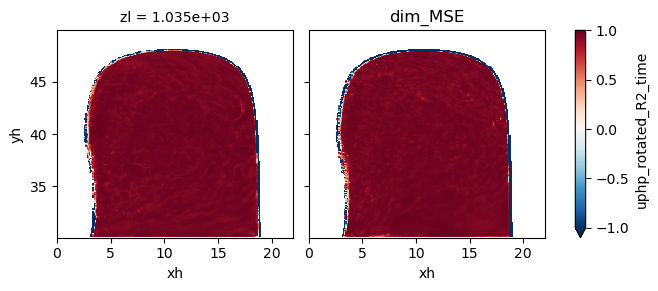

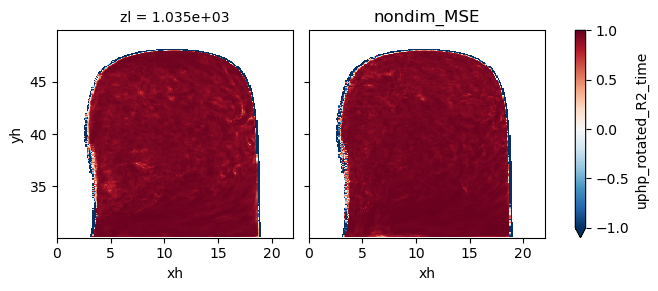

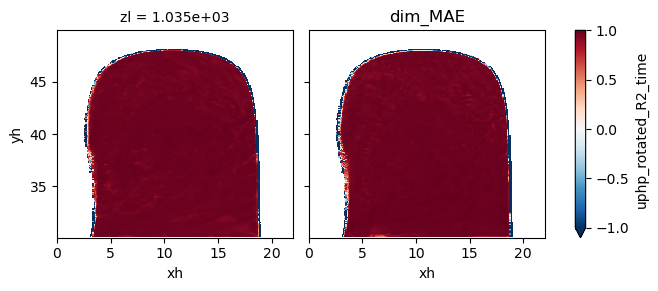

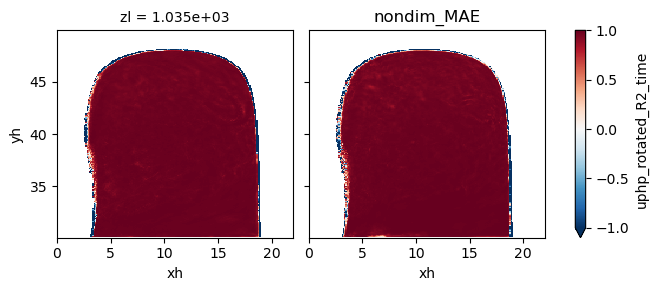

In [15]:
for key in experiment_config.keys():
    experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['50'].uphp_rotated_R2_time.plot(col='zl', vmin=-1)
    plt.title(key)

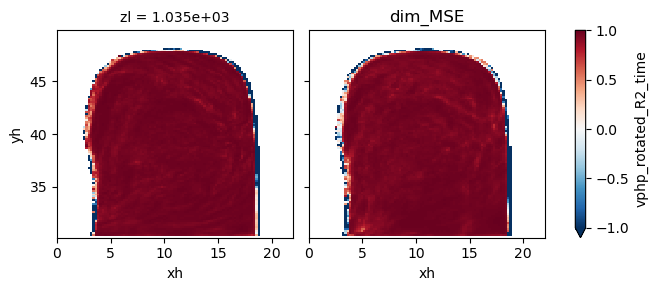

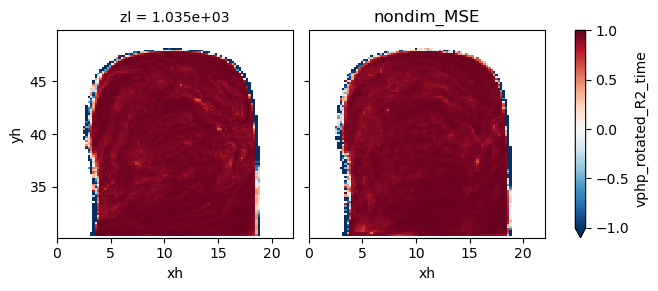

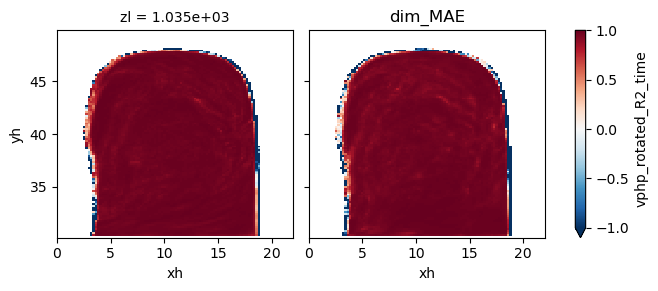

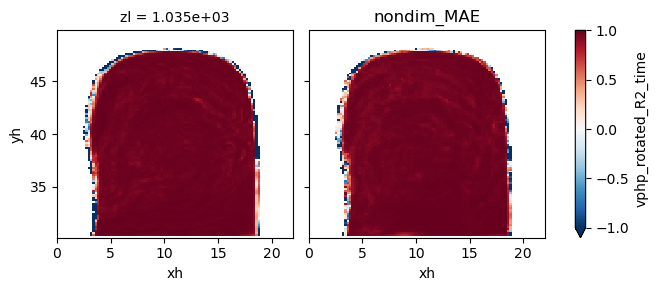

In [16]:
for key in experiment_config.keys():
    experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].vphp_rotated_R2_time.plot(col='zl', vmin=-1)
    plt.title(key)

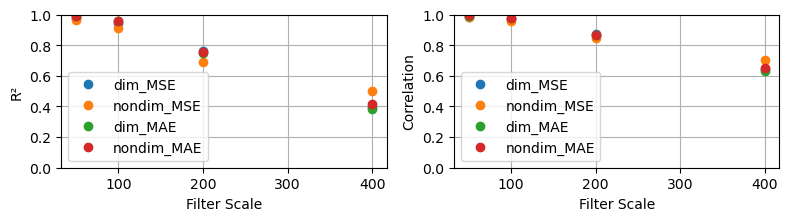

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

plt.subplot(2, 2, 1)

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5*(experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values + 
                        experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values )
        #num_batches = train_sets[model_key]['num_train_batches']
        
        # Use the same color for each model_key
        color = color_map[model_key]

        if flag == 0:
            plt.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            plt.plot(int(scale), R2_value, 'o', color=color, markersize=6)

plt.legend()
plt.xlabel("Filter Scale")
plt.ylabel("R²")
plt.ylim([0,1])
plt.grid()
#plt.title("Model Performance Across Scales for different batch sizes \n with number of parameters equal to " + str(num_params) )

#plt.savefig('impact_training_data.pdf')
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

plt.subplot(2,2,2)
# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5*(experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values + 
                        experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values )
        #num_batches = train_sets[model_key]['num_train_batches']
        
        # Use the same color for each model_key
        color = color_map[model_key]

        if flag == 0:
            plt.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            plt.plot(int(scale), R2_value, 'o', color=color, markersize=6)

plt.legend()
plt.xlabel("Filter Scale")
plt.ylabel("Correlation")
plt.ylim([0,1])
plt.grid()

plt.tight_layout()

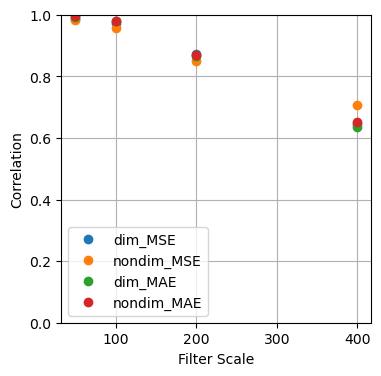

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5*(experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values + 
                        experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values )
        #num_batches = train_sets[model_key]['num_train_batches']
        
        # Use the same color for each model_key
        color = color_map[model_key]

        if flag == 0:
            plt.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            plt.plot(int(scale), R2_value, 'o', color=color, markersize=6)

plt.legend()
plt.xlabel("Filter Scale")
plt.ylabel("Correlation")
plt.ylim([0,1])
plt.grid()
#plt.title("Model Performance Across Scales for different batch sizes \n with number of parameters equal to " + str(num_params) )

#plt.savefig('impact_training_data.pdf')
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

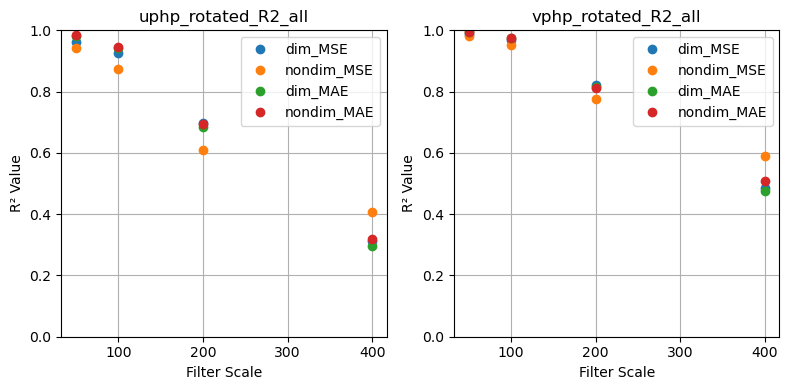

In [20]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 4))


var  = ['uphp_rotated_R2_all', 'vphp_rotated_R2_all']

for i, var_plot in enumerate(var):
    plt.subplot(1,2, 1+i)
    for model_key in experiment_config.keys():
        flag = 0
        exp_name = 'DG'
        for scale in common_config['filter_scales']:
            R2_value = experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale][var_plot].values
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color, markersize=6)
    
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title(var_plot)

plt.tight_layout()
#plt.title("Model Performance Across Scales for different batch sizes \n with number of parameters equal to " + str(num_params) )

#plt.savefig('impact_training_data.pdf')
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

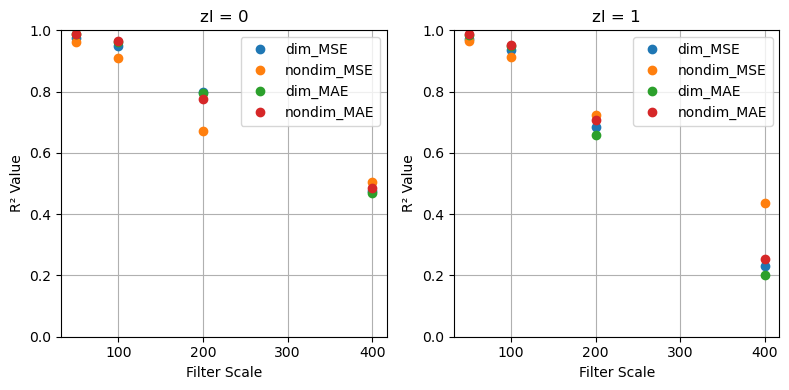

In [21]:
import matplotlib.pyplot as plt

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

plt.figure(figsize=(8, 4))

for zl in range(2):
    plt.subplot(1,2, 1+zl)
    for model_key in experiment_config.keys():
        flag = 0
        exp_name = 'DG'
        for scale in common_config['filter_scales']:
            R2_value = 0.5*(experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_layer_wise.isel(zl=zl).values + 
                            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_layer_wise.isel(zl=zl).values )
            #num_batches = train_sets[model_key]['num_train_batches']
            
            # Use the same color for each model_key
            color = color_map[model_key]
    
            if flag == 0:
                plt.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
                flag = 1
            else:
                plt.plot(int(scale), R2_value, 'o', color=color, markersize=6)
    
    plt.legend()
    plt.xlabel("Filter Scale")
    plt.ylabel("R² Value")
    plt.ylim([0,1])
    plt.grid()
    plt.title('zl = ' + str(zl))

plt.tight_layout()
#plt.title("Model Performance Across Scales for different batch sizes \n with number of parameters equal to " + str(num_params) )

#plt.savefig('impact_training_data.pdf')
#plt.savefig("figure.png", format="png", dpi=300, bbox_inches="tight")

In [36]:
for key in experiment_config.keys():
    experiment_config[key]['eval_sys'].calc_PS(var='uphp_rotated')
    experiment_config[key]['eval_sys'].calc_PS(var='vphp_rotated')

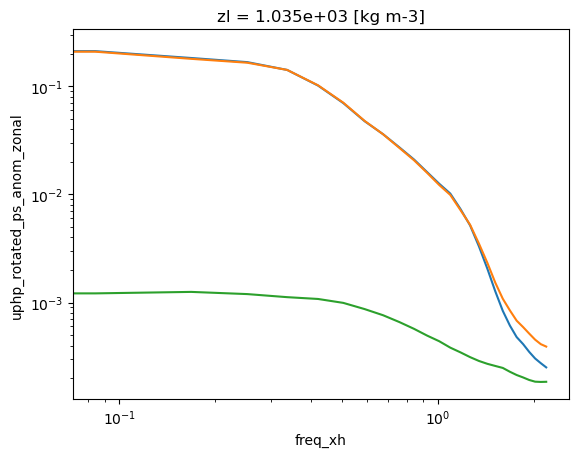

In [37]:
experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].vphp_rotated_ps_zonal.isel(zl=0).plot()
experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].vphp_rotated_ps_pred_zonal.isel(zl=0).plot()
experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_ps_anom_zonal.isel(zl=0).plot()
plt.xscale('log')
plt.yscale('log')

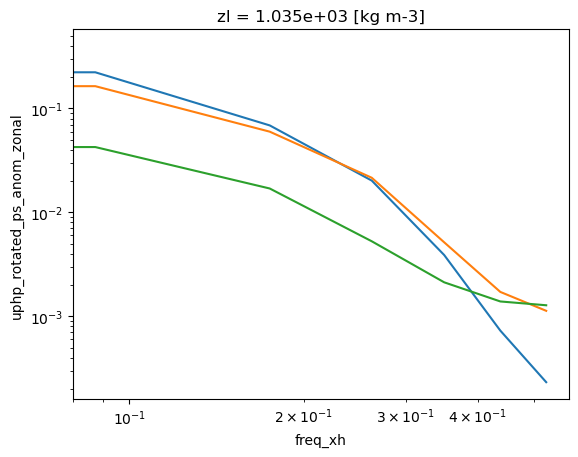

In [38]:
experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['400'].vphp_rotated_ps_zonal.isel(zl=0).plot()
experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['400'].vphp_rotated_ps_pred_zonal.isel(zl=0).plot()
experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['400'].uphp_rotated_ps_anom_zonal.isel(zl=0).plot()
plt.xscale('log')
plt.yscale('log')

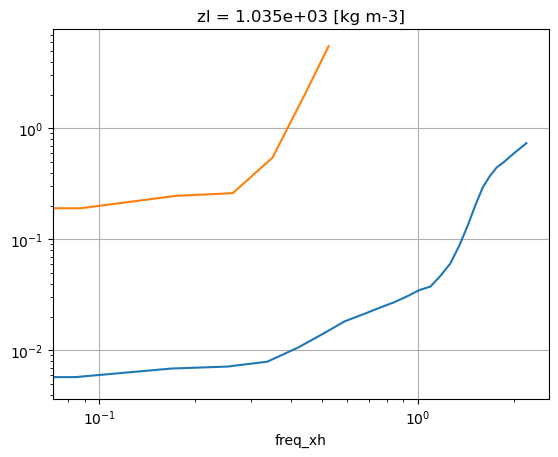

In [42]:
(experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].uphp_rotated_ps_anom_zonal.isel(zl=0) / experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['100'].vphp_rotated_ps_zonal.isel(zl=0)).plot()

(experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['400'].uphp_rotated_ps_anom_zonal.isel(zl=0) / experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG']['400'].vphp_rotated_ps_zonal.isel(zl=0)).plot()
plt.xscale('log')
plt.yscale('log')
plt.grid('on')

In [28]:
experiment_config['dim_MAE']['fig_label'] = 'Dim., MAE'
experiment_config['nondim_MAE']['fig_label'] = 'Non. Dim., MAE'
experiment_config['dim_MSE']['fig_label'] = 'Dim., MSE'
experiment_config['nondim_MSE']['fig_label'] = 'Non. Dim., MSE'

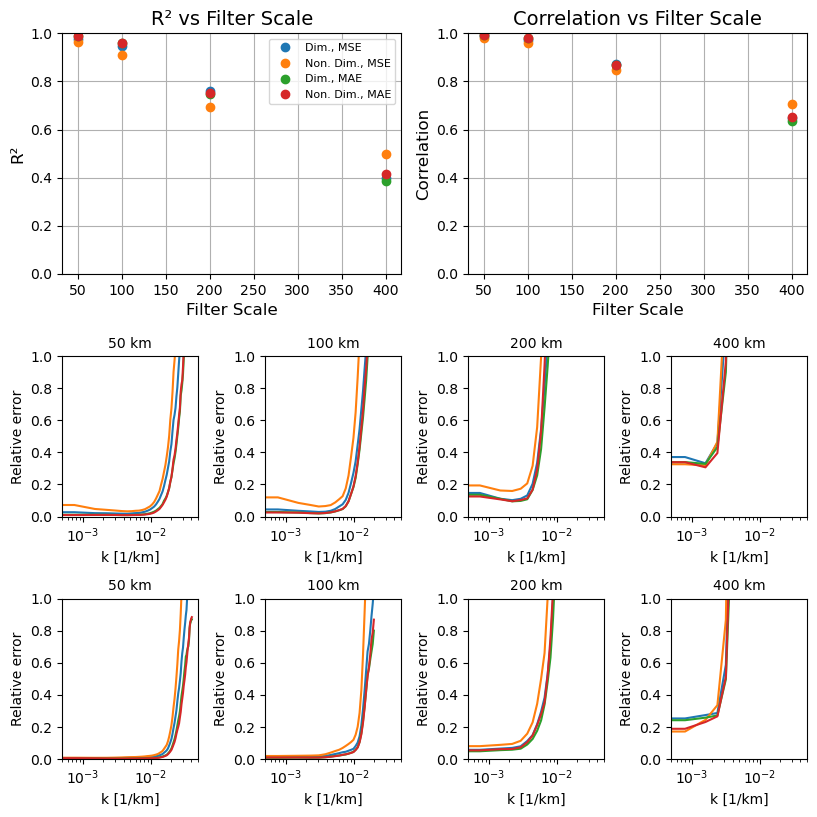

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define figure size for A4 sheet in inches (portrait layout)
fig = plt.figure(figsize=(8.27, 8.27))

# Create a grid layout with 3 rows and 4 columns
gs = gridspec.GridSpec(3, 4, height_ratios=[1.5, 1, 1])  # Top row is taller

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

## First Row: R² vs Filter Scale (Left) & Correlation vs Filter Scale (Right)
ax1 = fig.add_subplot(gs[0, :2])  # First plot spans two columns
ax2 = fig.add_subplot(gs[0, 2:])  # Second plot spans the other two columns

# Plot R² vs Filter Scale
for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5 * (
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values +
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax1.plot(int(scale), R2_value, 'o', label=experiment_config[model_key]['fig_label'], color=color, markersize=6)
            flag = 1
        else:
            ax1.plot(int(scale), R2_value, 'o', color=color, markersize=6)

ax1.legend(fontsize=8)
ax1.set_xlabel("Filter Scale", fontsize=12)
ax1.set_ylabel("R²", fontsize=12)
ax1.set_ylim([0, 1])
ax1.grid()
ax1.set_title("R² vs Filter Scale", fontsize=14)

# Plot Correlation vs Filter Scale
for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5 * (
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values +
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax2.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            ax2.plot(int(scale), R2_value, 'o', color=color, markersize=6)

#ax2.legend(fontsize=8)
ax2.set_xlabel("Filter Scale", fontsize=12)
ax2.set_ylabel("Correlation", fontsize=12)
ax2.set_ylim([0, 1])
ax2.grid()
ax2.set_title("Correlation vs Filter Scale", fontsize=14)

## Second Row: uphp_rotated_ps_anom_zonal / uphp_rotated_ps_zonal (Smaller)
for i, scale in enumerate(common_config['filter_scales']):
    ax = fig.add_subplot(gs[1, i])
    for key in experiment_config.keys():
        ds = experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG'][scale]
        ax.plot(ds.freq_xh / 110, 
                (ds.uphp_rotated_ps_anom_zonal / ds.uphp_rotated_ps_zonal).isel(zl=0).data, 
                color=color_map[key], label=key)
    
    ax.set_xscale('log')
    ax.set_ylim([0, 1])
    ax.set_xlim([1/2000, 1/20])
    ax.set_title(f"{scale} km", fontsize=10)
    ax.set_xlabel("k [1/km]", fontsize=10)
    ax.set_ylabel("Relative error", fontsize=10)

## Third Row: vphp_rotated_ps_anom_zonal / vphp_rotated_ps_zonal (Smaller)
for i, scale in enumerate(common_config['filter_scales']):
    ax = fig.add_subplot(gs[2, i])
    for key in experiment_config.keys():
        ds = experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG'][scale]
        ax.plot(ds.freq_xh / 110, 
                (ds.vphp_rotated_ps_anom_zonal / ds.vphp_rotated_ps_zonal).isel(zl=0).data, 
                color=color_map[key], label=key)

    ax.set_xscale('log')
    ax.set_ylim([0, 1])
    ax.set_xlim([1/2000, 1/20])
    ax.set_title(f"{scale} km", fontsize=10)
    ax.set_xlabel("k [1/km]", fontsize=10)
    ax.set_ylabel("Relative error", fontsize=10)

# Add legend only once
#fig.legend(fontsize=8, loc="upper right")

plt.tight_layout()
plt.savefig("impact_loss_style.pdf", format="pdf", dpi=300, bbox_inches="tight")  # High-res for printing
plt.show()


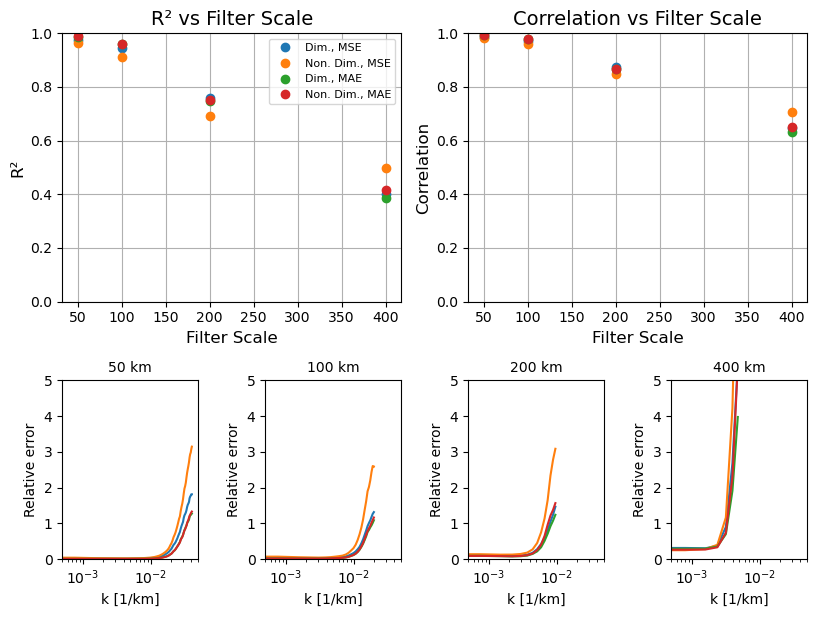

In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define figure size for A4 sheet in inches (portrait layout)
fig = plt.figure(figsize=(8.27, 6.27))

# Create a grid layout with 3 rows and 4 columns
gs = gridspec.GridSpec(2, 4, height_ratios=[1.5, 1])  # Top row is taller

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

## First Row: R² vs Filter Scale (Left) & Correlation vs Filter Scale (Right)
ax1 = fig.add_subplot(gs[0, :2])  # First plot spans two columns
ax2 = fig.add_subplot(gs[0, 2:])  # Second plot spans the other two columns

# Plot R² vs Filter Scale
for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5 * (
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values +
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax1.plot(int(scale), R2_value, 'o', label=experiment_config[model_key]['fig_label'], color=color, markersize=6)
            flag = 1
        else:
            ax1.plot(int(scale), R2_value, 'o', color=color, markersize=6)

ax1.legend(fontsize=8)
ax1.set_xlabel("Filter Scale", fontsize=12)
ax1.set_ylabel("R²", fontsize=12)
ax1.set_ylim([0, 1])
ax1.grid()
ax1.set_title("R² vs Filter Scale", fontsize=14)

# Plot Correlation vs Filter Scale
for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5 * (
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values +
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax2.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            ax2.plot(int(scale), R2_value, 'o', color=color, markersize=6)

#ax2.legend(fontsize=8)
ax2.set_xlabel("Filter Scale", fontsize=12)
ax2.set_ylabel("Correlation", fontsize=12)
ax2.set_ylim([0, 1])
ax2.grid()
ax2.set_title("Correlation vs Filter Scale", fontsize=14)

## Second Row: uphp_rotated_ps_anom_zonal / uphp_rotated_ps_zonal (Smaller)
for i, scale in enumerate(common_config['filter_scales']):
    ax = fig.add_subplot(gs[1, i])
    for key in experiment_config.keys():
        ds = experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG'][scale]
        ax.plot(ds.freq_xh / 110, 
                ( 0.5*((ds.uphp_rotated_ps_anom_zonal / ds.uphp_rotated_ps_zonal) + (ds.vphp_rotated_ps_anom_zonal / ds.vphp_rotated_ps_zonal)) ).isel(zl=0).data, 
                color=color_map[key], label=key)
    
    ax.set_xscale('log')
    ax.set_ylim([0, 5])
    ax.set_xlim([1/2000, 1/20])
    ax.set_title(f"{scale} km", fontsize=10)
    ax.set_xlabel("k [1/km]", fontsize=10)
    ax.set_ylabel("Relative error", fontsize=10)


# Add legend only once
#fig.legend(fontsize=8, loc="upper right")

plt.tight_layout()
plt.savefig("impact_loss_style.pdf", format="pdf", dpi=300, bbox_inches="tight")  # High-res for printing
plt.show()


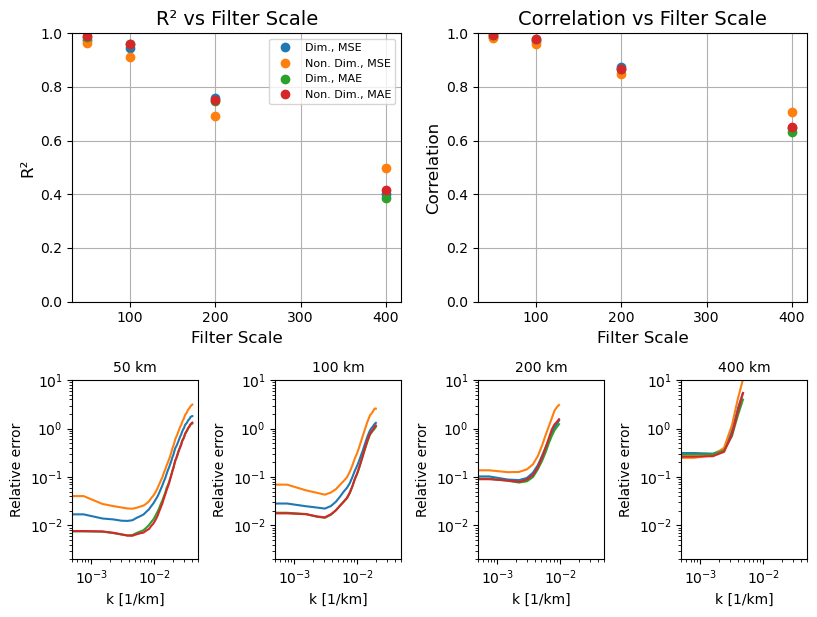

In [44]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define figure size for A4 sheet in inches (portrait layout)
fig = plt.figure(figsize=(8.27, 6.27))

# Create a grid layout with 3 rows and 4 columns
gs = gridspec.GridSpec(2, 4, height_ratios=[1.5, 1])  # Top row is taller

# Define a color map for model_keys
color_map = {key: color for key, color in zip(experiment_config.keys(), plt.cm.tab10.colors)}

## First Row: R² vs Filter Scale (Left) & Correlation vs Filter Scale (Right)
ax1 = fig.add_subplot(gs[0, :2])  # First plot spans two columns
ax2 = fig.add_subplot(gs[0, 2:])  # Second plot spans the other two columns

# Plot R² vs Filter Scale
for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5 * (
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_R2_all.values +
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_R2_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax1.plot(int(scale), R2_value, 'o', label=experiment_config[model_key]['fig_label'], color=color, markersize=6)
            flag = 1
        else:
            ax1.plot(int(scale), R2_value, 'o', color=color, markersize=6)

ax1.legend(fontsize=8)
ax1.set_xlabel("Filter Scale", fontsize=12)
ax1.set_ylabel("R²", fontsize=12)
ax1.set_ylim([0, 1])
ax1.grid()
ax1.set_title("R² vs Filter Scale", fontsize=14)

# Plot Correlation vs Filter Scale
for model_key in experiment_config.keys():
    flag = 0
    exp_name = 'DG'
    for scale in common_config['filter_scales']:
        R2_value = 0.5 * (
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].uphp_rotated_corr_all.values +
            experiment_config[model_key]['eval_sys'].eval_datatree.ml_dataset[exp_name][scale].vphp_rotated_corr_all.values
        )
        color = color_map[model_key]
        if flag == 0:
            ax2.plot(int(scale), R2_value, 'o', label=model_key, color=color, markersize=6)
            flag = 1
        else:
            ax2.plot(int(scale), R2_value, 'o', color=color, markersize=6)

#ax2.legend(fontsize=8)
ax2.set_xlabel("Filter Scale", fontsize=12)
ax2.set_ylabel("Correlation", fontsize=12)
ax2.set_ylim([0, 1])
ax2.grid()
ax2.set_title("Correlation vs Filter Scale", fontsize=14)

## Second Row: uphp_rotated_ps_anom_zonal / uphp_rotated_ps_zonal (Smaller)
for i, scale in enumerate(common_config['filter_scales']):
    ax = fig.add_subplot(gs[1, i])
    for key in experiment_config.keys():
        ds = experiment_config[key]['eval_sys'].eval_datatree.ml_dataset['DG'][scale]
        ax.plot(ds.freq_xh / 110, 
                ( 0.5*((ds.uphp_rotated_ps_anom_zonal / ds.uphp_rotated_ps_zonal) + (ds.vphp_rotated_ps_anom_zonal / ds.vphp_rotated_ps_zonal)) ).isel(zl=0).data, 
                color=color_map[key], label=key)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([2e-3, 10])
    ax.set_xlim([1/2000, 1/20])
    ax.set_title(f"{scale} km", fontsize=10)
    ax.set_xlabel("k [1/km]", fontsize=10)
    ax.set_ylabel("Relative error", fontsize=10)


# Add legend only once
#fig.legend(fontsize=8, loc="upper right")

plt.tight_layout()
plt.savefig("impact_loss_style.pdf", format="pdf", dpi=300, bbox_inches="tight")  # High-res for printing
plt.show()
